In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LinearRegression
#------------------------------------------------------
housing=pd.read_csv('housing.csv')
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)
train_set.shape
train_set.head(100)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11471,-118.00,33.67,34.0,3712.0,667.0,1521.0,632.0,4.8125,387800.0,<1H OCEAN
11886,-117.37,33.99,44.0,917.0,224.0,666.0,220.0,1.6850,114200.0,INLAND
1989,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,47500.0,INLAND
16457,-121.29,38.13,20.0,3168.0,514.0,1390.0,490.0,5.0000,154800.0,INLAND


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

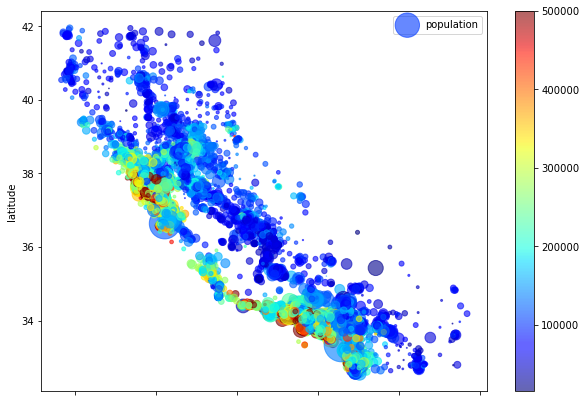

In [5]:
date=train_set.copy()
date.plot(kind="scatter",x="longitude",y="latitude",
          s=date["population"]/30,label="population",  #   نمودار بر اساس جمعیت و شعاع وبا عنوان جمعیت و هر داده در ستون جمعیت تقسیم بر 30
          figsize=(10,7),  #size
          c=date["median_house_value"], cmap=plt.get_cmap("jet"), #داده های ستون قیمت را بر اساس رنگ بندی قرمز تا ابی نمایش  میدهد
          alpha=0.6,) #شفافیت

In [6]:
# ضریب استاندارد وابستگی "مشکل ان خطی بودن ان است"[-1,1]
corr_matrix= date.corr()
corr_matrix["median_house_value"].sort_values(ascending=False) #ماتریکس که ساختیم از ستون قیمت خانه ها به سورت صعودی مرتب می کند

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

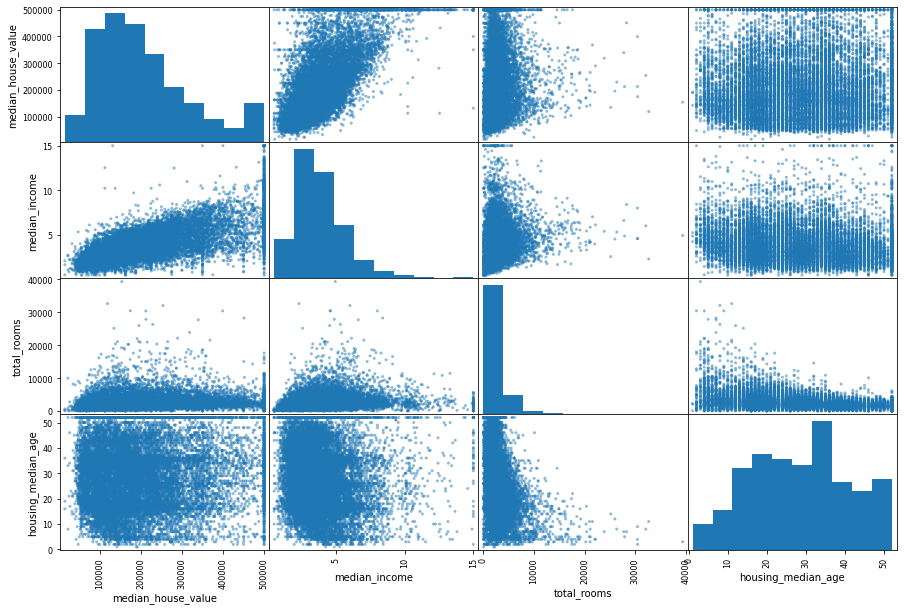

In [7]:
# نمایش نمودار های ستون های وابسته به قیمت خونه ها
arryfeatures=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(date[arryfeatures],figsize=(15,10))
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

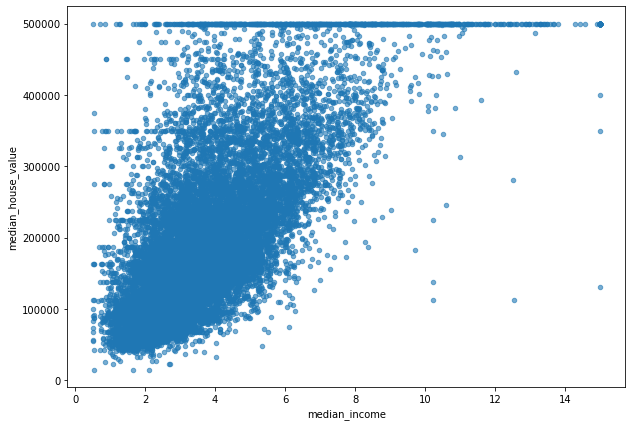

In [8]:
#ستونی  که بیشترین تاثیر در قیمت خونه ها رو دارد  انتخاب میکنیم
date.plot(kind="scatter",x="median_income",y="median_house_value",figsize=(10,7),alpha=0.6,)

In [9]:
#بخش آخر دیدن داده ها ترکیب چند ستون و به دست اوردن داده جدید و اینکه ایا تاثیر دارد تو قیمت خانه یا نه
date["population_per_households"]=date["population"]/date["households"]
date["total_rooms_per_households"]=date["total_rooms"]/date["households"]
date["total_bedrooms_per_total_rooms"]=date["total_bedrooms"]/date["total_rooms"]
#از اول از استاندارد تابع خطی استفاده میکنیم
corr_matrix=date.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value                1.000000
median_income                     0.690647
total_rooms_per_households        0.158485
total_rooms                       0.133989
housing_median_age                0.103706
households                        0.063714
total_bedrooms                    0.047980
population_per_households        -0.022030
population                       -0.026032
longitude                        -0.046349
latitude                         -0.142983
total_bedrooms_per_total_rooms   -0.257419
Name: median_house_value, dtype: float64

In [10]:
#استفاده از کلاس پایپلاین برای اینکه گروهی از دستوراتی که ما میدیم روی داده های جدید اجرا کند
#مانند قبل سه ستون تاثیر گزار را وارد داده ها میکنیم 
rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6
class ComboinAttributesAdder(BaseEstimator,TransformerMixin):
        def fit(self,x,y=None):
            return self
        def transform(self,x,y=None):
            rooms_per_household=x[:,rooms_ix]/x[:,household_ix]
            population_perhousehold=x[:,population_ix]/x[:,household_ix]
            bedrooms_per_room=x[:,bedrooms_ix]/x[:,room_ix]
            return np.c_[x,rooms_per_household,population_perhousehold,bedrooms_per_room]
#داده های عددیو غیر عدیدی را جدا میکند در واقع ستون های عدیدی را میکشیم بیرون 
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names=attribute_names
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        return x[self.attribute_names].values
#ستون رشته را حذف میکنیم و بقیه داده هارو میریزم تو df متغیر
df=train_set.copy()
df_label=df["median_house_value"].copy()
df=df.drop("median_house_value",axis=1)
df_num=df.drop(["ocean_proximity"],axis=1)
num_attres= list(df_num)  #این تابع اسم ستون های عدیدی را میده
cat_attres=["ocean_proximity"] #ارایه ای که ستون متنی توی اون هست
#باید ستون عددی بگیره و از کل داده ها فقط ستون های که مشخص کردیم پیدا میکنه 
#مدین را پیدا میکند
num_pipeline=Pipeline([
     ('selector',DataFrameSelector(num_attres)),
     ('imputer',SimpleImputer(missing_values=np.nan,strategy='median')),
     ('attribs_adder',ComboinAttributesAdder()),
     ('std_scaler',StandardScaler())
     ])

cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_attres)),
    ('one_hot_encoder',OneHotEncoder(sparse=False))
    ])
#ترکیبی از دو تابع بالا درست میکنیم
full_pipeline=FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline)
    ])
housing_perpared=full_pipeline.fit_transform(df)
housing_perpared_df=pd.DataFrame(housing_perpared,columns=[
    'longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population',
    'households','median_income','rooms_per_household','population_perhousehold','bedrooms_per_room',
    'prox_<1H OCEAN','prox_INLAND','prox_ISLAND','prox_NEAR OCEAN'])
housing_perpared_df.head()

NameError: name 'room_ix' is not defined

In [11]:
#حال باید از داده های تمیز شده و مرتب شده استفاده کنیم و اموزششون بدیم
#---------------------------------------------------------------
#رگرسیون خطی

lin_reg= LinearRegression()
lin_reg.fit(housing_perpred_df,df_label)
sample_tata_perpred=housing_prepared_df.iloc[:4]
print("Prediction:\t",lin_reg.predict(sample_data_perpread))
sample_labels=df_label.iloc[:4]
print("Labels:\t\t",list(sample_labels))

NameError: name 'housing_perpred_df' is not defined

In [12]:
from sklearn.metrics import mean_squared_error

#داده ها را میدهیم و برای ما پیشبینی میکند 
#هرچی از میانگین دور باشد ینی الگریتم ما بدرد نمیخورد
housing_perdictions= lin_reg.predict(housing_perpared_df)
lin_mse=mean_squared_error(df_label,housing_perdictions)
lin_rmse=np.aqrt(lin_mse)
lin_rmse

NameError: name 'housing_perpared_df' is not defined